In [1]:
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import scipy as sci
import seaborn as sns

import datetime
import autogenes as ag

import matplotlib as mpl
import matplotlib.pyplot as plt

import re

/home/trc891/.conda/envs/cfn_final/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/trc891/.conda/envs/cfn_final/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/trc891/.conda/envs/cfn_final/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/trc891/.conda/envs/cfn_final/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/trc891/.conda/envs/cfn_final/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Impor

In [2]:
# Code borrowed from Nick

#select replicate indices and save their sum
def removeReplicas(adata):
    #find genes with a '.' in their name
    noreplica = adata.var.loc[~adata.var.index.str.contains("\\."),:].index
    print(adata[:,noreplica])
    replicas = adata.var.loc[adata.var.index.str.contains("\\."),:].index
    uniques = set()
    new_var_names = set()
    for x in replicas: 
        uniques.add(x.split(".")[0])
        new_var_names.add(x.split(".")[0])
    new_var_names.update(noreplica.tolist())
    adata_new = sc.AnnData(np.zeros((len(adata.obs_names),len(new_var_names))))
    adata_new.var_names = list(new_var_names)
    adata_new.obs_names = adata.obs_names
    adata_new[:,noreplica].X = adata[:,noreplica].X
    adata_new.obs = adata.obs
    for x in uniques:
        ind = adata.var.loc[adata.var.index.str.contains(x),:].index
        if(len(ind)!=1):
            adata_new[:,x].X = np.sum(adata[:,ind].X,axis=1)
        else:
            adata_new[:,x].X =  adata[:,ind[0]].X
    return adata_new

def normalize_proportions(data,copy):
    if copy==True:
        data_copy = data.copy()
    else:
        data_copy = data
    data_copy[data_copy < 0] = 0
    for raw in data_copy.index:
        sum = data_copy.loc[raw].sum()
        if sum!=0:
            data_copy.loc[raw] = np.divide(data_copy.loc[raw],sum)
        else:
            data_copy.loc[raw] = 0
    return data_copy

## Load 3173 bulk data

In [4]:
DATA_DIR = '../../data/03CF_3173'
SALMON_DIR = f'{DATA_DIR}/nf_rnaseq_grch38_v113_out/star_salmon'

nextflow_samples = pd.read_csv(f'{DATA_DIR}/samplesheet.csv')
demo = pd.read_csv(f'{DATA_DIR}/3173_samples_20240913.csv')
tx2gene = pd.read_csv(f'{SALMON_DIR}/salmon_tx2gene.tsv', sep='\t', names=["TXNAME", "GENEID", "GENENAME"])

ct_df = pd.read_csv(f'{SALMON_DIR}/salmon.merged.gene_counts.tsv', sep='\t', index_col=1)
#ct_df = pd.read_csv(f'{SALMON_DIR}/salmon.merged.gene_counts_scaled.tsv', sep='\t', index_col=1)

del ct_df['gene_id']

demo['SampleID'] = ['X{}'.format(x) if x[0].isnumeric() else x for x in demo['SampleID']]

bulk_ds = sc.AnnData(X=ct_df.T, obs=demo.set_index('SampleID'))

/home/trc891/.conda/envs/cfn_final/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
ct_df

,X01CF_S9,X20230119uRNA1_S52,X25CF_S33,CF02_S10,CF03_S11,CF04_S12,CF05_S13,CF06_S14,CF07_S15,CF08_S16,...,CF43_S51,NC001_S1,NC002_RLT_S3,NC002_S2,NC003_S4,NC004_S5,NC005_S6,NC006_S7,NC007_S8,Undetermined_S0
gene_name,,,,,,,,,,,,,,,,,,,,,
TSPAN6,1528.0,419.000,19.0,2173.936,1272.000,695.0,109.000,2144.000,620.000,1764.000,...,1342.0,2401.0,1357.000,937.000,965.000,2226.000,818.000,2294.000,1711.000,3827.694
TNMD,0.0,8.000,4.0,0.000,2.000,0.0,3.000,0.000,1.000,18.000,...,0.0,0.0,9.000,0.000,1.000,0.000,6.000,1.000,1.000,32.261
DPM1,267.0,610.001,15.0,401.000,266.000,236.0,43.000,270.000,201.998,194.000,...,299.0,330.0,201.000,229.001,238.999,312.999,236.000,329.730,289.001,740.361
SCYL3,299.0,236.991,19.0,359.949,307.000,178.0,58.114,461.999,147.000,364.007,...,375.0,566.0,392.000,301.190,223.000,475.999,235.000,299.000,523.999,1563.034
FIRRM,17.0,166.061,9.0,60.000,29.426,79.0,11.000,37.911,30.000,56.000,...,48.0,166.0,107.832,73.813,33.000,35.000,86.980,68.000,48.000,175.143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000310553,0.0,0.000,0.0,1.010,0.000,0.5,1.000,0.000,0.500,0.000,...,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
ENSG00000310554,0.0,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,...,0.0,0.0,0.000,2.000,0.000,0.000,0.000,0.558,0.000,2.408
ENSG00000310555,0.0,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,...,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500


In [6]:
bulk_ds

AnnData object with n_obs × n_vars = 53 × 78932
    obs: 'Sample', 'Sample_old', 'Class', 'RIN', 'CFTRMod', 'ModType', 'ppFEV1', 'Age', 'Sex', 'PsA', 'F508delStatus', 'HEMTStatus'

In [7]:
bulk_ds.var_names_make_unique()
bulk_ds = removeReplicas(bulk_ds) # this takes a while...

/home/trc891/.conda/envs/cfn_final/lib/python3.10/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(


View of AnnData object with n_obs × n_vars = 53 × 78922
    obs: 'Sample', 'Sample_old', 'Class', 'RIN', 'CFTRMod', 'ModType', 'ppFEV1', 'Age', 'Sex', 'PsA', 'F508delStatus', 'HEMTStatus'


In [8]:
bulk_proc = bulk_ds.copy()
sc.pp.normalize_per_cell(bulk_proc, counts_per_cell_after=1e4, copy=False)

## Load Alexandria Data

In [9]:
adata = sc.read_text(f'../../data/03CF_3173/shalek_2018/20180921_PolypScrape_cleaned_data.txt.gz', delimiter='\t').T
meta_data = pd.read_csv('../../data/03CF_3173/shalek_2018/np_alexandria_meta_with_sss.csv', sep=',', index_col=0)

/tmp/ipykernel_143157/2354213579.py:2: DtypeWarning: Columns (6,10,11,16,17,33,35) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_data = pd.read_csv('../../data/03CF_3173/shalek_2018/np_alexandria_meta_with_sss.csv', sep=',', index_col=0)


In [10]:
adata.X = np.expm1(adata.X)

In [11]:
len(np.intersect1d(meta_data.index, adata.obs_names))

18704

In [12]:
meta_data = meta_data.drop('TYPE',axis=0)
meta_data = meta_data.loc[adata.obs_names,:]

for s in meta_data.columns.values:
    adata.obs[s] = meta_data[s].tolist()

In [13]:
adata_proc = adata.copy()

In [14]:
sc.pp.normalize_per_cell(adata_proc, counts_per_cell_after=1e4, copy=False)
adata_log = sc.pp.log1p(adata_proc, copy=True)

### Find HVGs

In [15]:
n_top_genes = 5000
sc.pp.highly_variable_genes(adata_log, flavor='seurat', n_top_genes=n_top_genes)

In [16]:
sc.tl.pca(adata_log)
adata_log.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat


sc.pp.neighbors(adata_log, n_neighbors=30)
sc.tl.umap(adata_log)

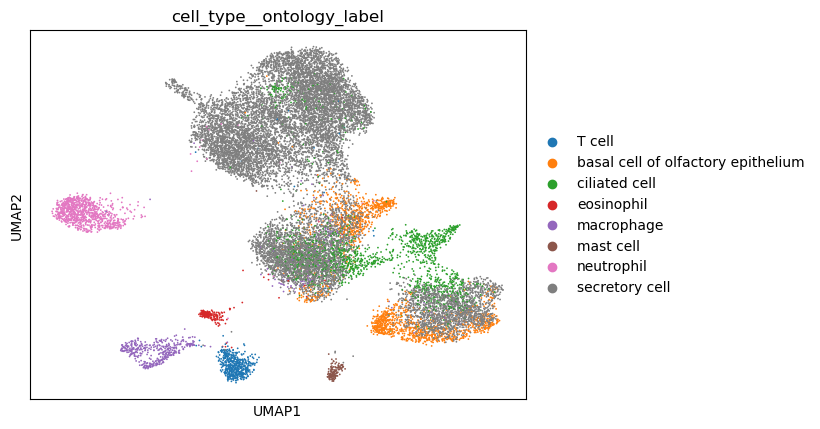

In [17]:
sc.pl.umap(adata_log,color='cell_type__ontology_label')

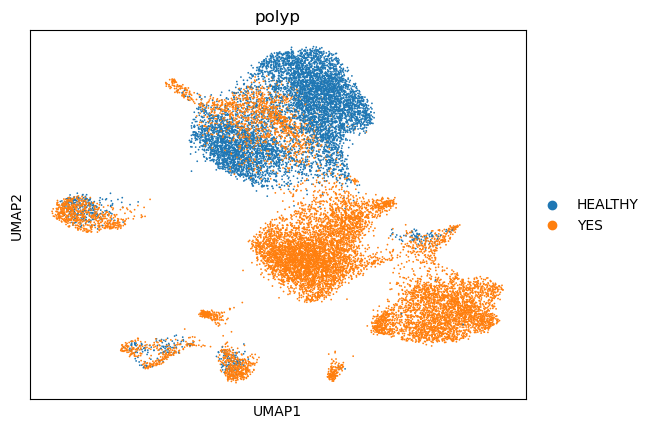

In [18]:
sc.pl.umap(adata_log, color='polyp')

In [19]:
shared_hv = np.intersect1d(adata_proc[:, adata_log.var_names[adata_log.var['highly_variable']==True]].var_names,
                           bulk_ds.var_names
                          )

In [20]:
adata_hv = adata_proc[:,shared_hv].copy()

## Train AutoGeneS

In [21]:
print(datetime.datetime.now())
time0 = datetime.datetime.now()

ngenes = 400 
ngen=5000
centroids = ag.init(adata_hv, use_highly_variable=False, celltype_key='cell_type__ontology_label')
ag.optimize(ngen=ngen, seed=0, nfeatures=ngenes, mode='fixed', verbose=False)

print(datetime.datetime.now()-time0)

2025-03-07 11:15:19.752626
0:06:22.587230


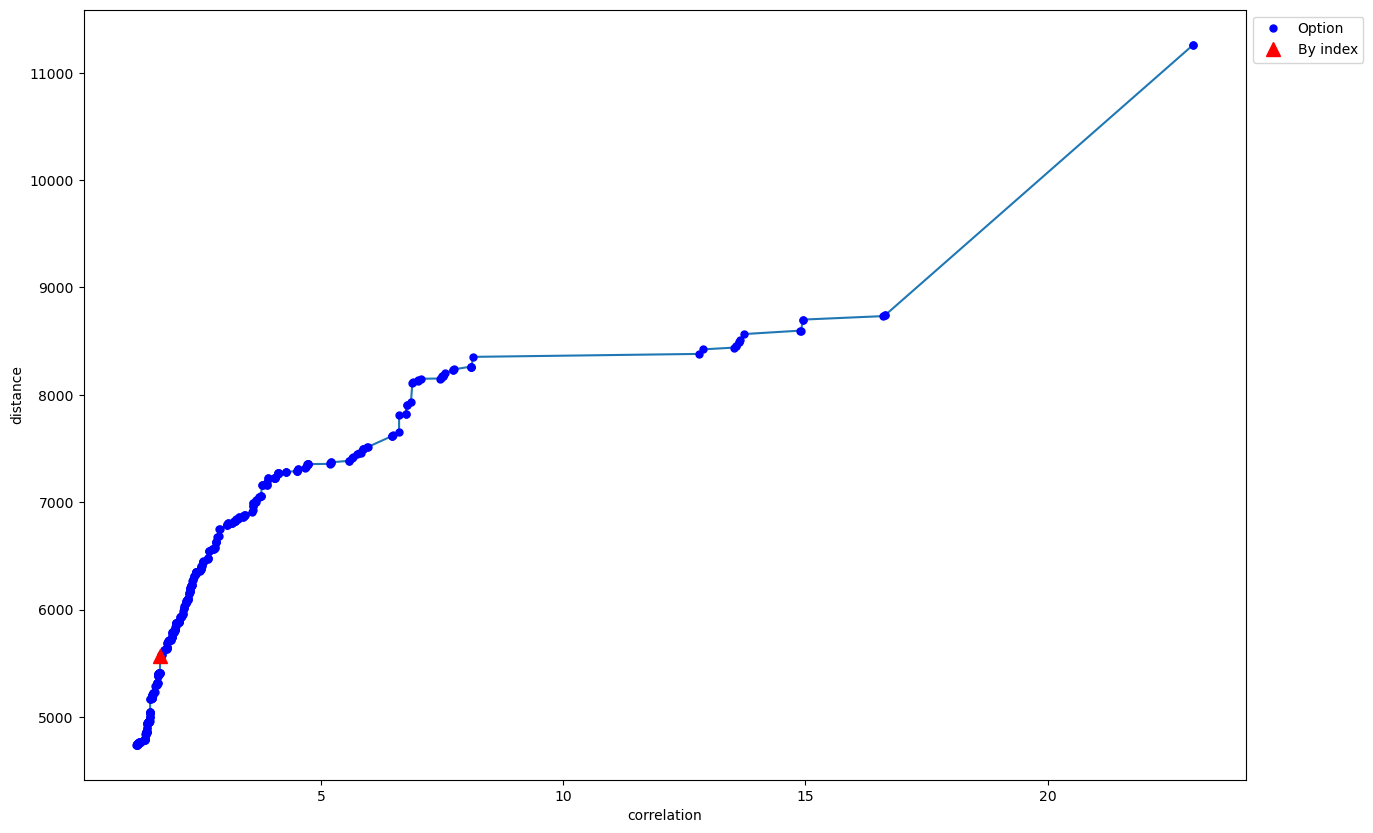

In [22]:
pareto = 155

ag.plot(index=pareto)
selection = ag.select(index=pareto)

centroids_sc_pareto = pd.DataFrame(centroids[:,selection].X.T,index=centroids[:,selection].var_names,columns=centroids[:,selection].obs_names)

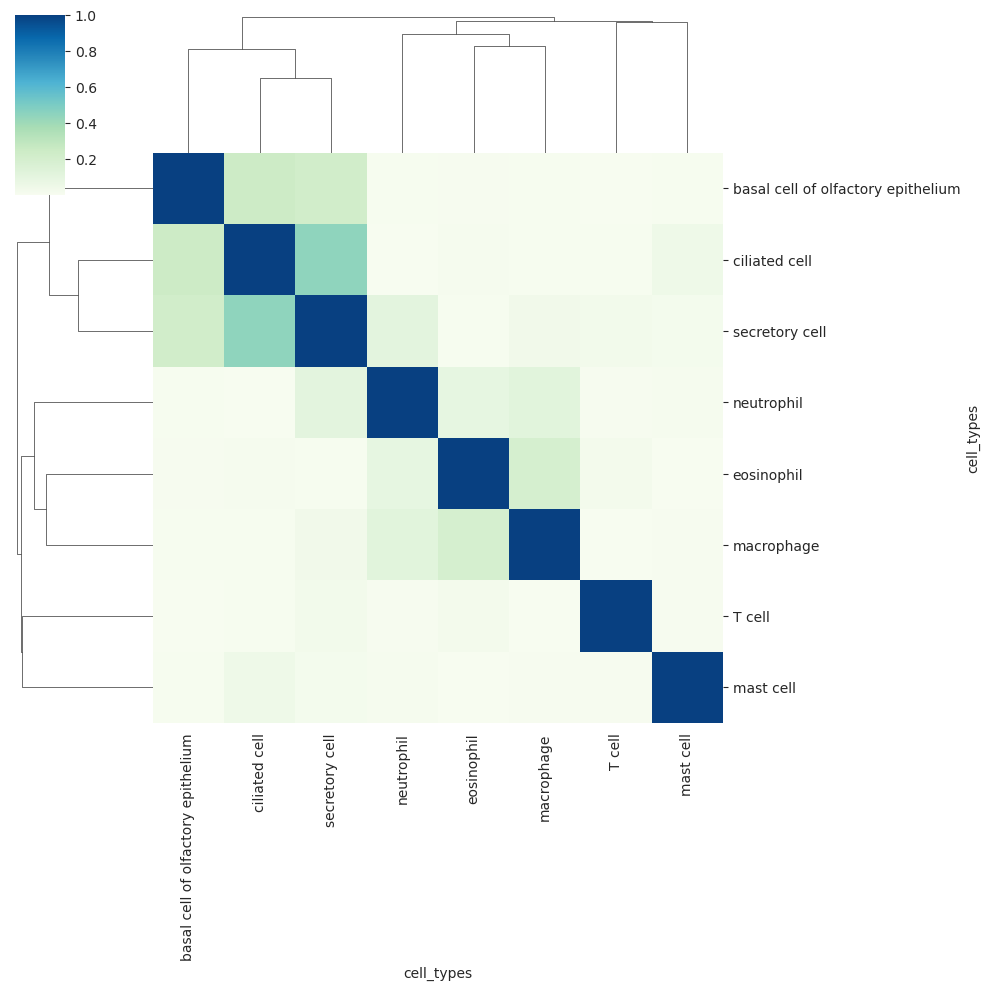

In [23]:
corr = pd.DataFrame(data = np.corrcoef(centroids_sc_pareto.T), columns = centroids_sc_pareto.columns, index = centroids_sc_pareto.columns)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns_plot =sns.clustermap(np.abs(corr),cmap=sns.color_palette("GnBu", 1000), robust=True)

## Deconvolve CF_3173 Bulk

In [24]:
# Remove poor quality samples (See 01.1fig1_R.ipynb)
filt_list = ['NC002_RLT_S3', 'CF31_S37', 'CF31_v2_S40', 'CF27_S35', 'X25CF_S33', 'X20230119uRNA1_S52']
bulk_proc = bulk_proc[~bulk_proc.obs_names.isin(filt_list)]

# Remove RIN<6.5
bulk_proc = bulk_proc[bulk_proc.obs['RIN'] >= 6.5]

bulk_proc

View of AnnData object with n_obs × n_vars = 33 × 78932
    obs: 'Sample', 'Sample_old', 'Class', 'RIN', 'CFTRMod', 'ModType', 'ppFEV1', 'Age', 'Sex', 'PsA', 'F508delStatus', 'HEMTStatus', 'n_counts'

In [25]:
bulk_proc.obs.shape

(33, 13)

In [26]:
absent_bulk = shared_hv[~np.isin(shared_hv, bulk_proc.var_names)]
absent_bulk

array([], dtype=object)

In [27]:
absent_zeros_bulk = np.zeros((bulk_proc.shape[0], absent_bulk.size))
new_X_bulk = np.hstack([bulk_proc.X, absent_zeros_bulk])
new_var_bulk = pd.concat([bulk_proc.var, pd.DataFrame(index=absent_bulk)])

bulk_proc2 = sc.AnnData(new_X_bulk, obs=bulk_proc.obs, var=new_var_bulk)
bulk_hv = bulk_proc2[:, shared_hv]

In [28]:
coef_nnls_bulk = ag.deconvolve(bulk_hv.X, model='nnls') #model='nusvr'
coef_nnls_bulk.shape

(33, 8)

In [29]:
proportions_nnls_bulk = pd.DataFrame(data=coef_nnls_bulk.T, index=centroids_sc_pareto.columns, columns=bulk_hv.obs_names)
proportions_nnls_norm_bulk = normalize_proportions(proportions_nnls_bulk.T, copy=True).T

proportions_nnls_norm_bulk = proportions_nnls_norm_bulk.set_index(proportions_nnls_norm_bulk.index)
proportions_nnls_norm_bulk=proportions_nnls_norm_bulk.astype(float)

proportions_bulk = proportions_nnls_norm_bulk.copy()#loc[:,real_prop.index]

In [30]:
proportions_bulk

SampleID,X01CF_S9,CF02_S10,CF03_S11,CF04_S12,CF08_S16,CF10_S18,CF11_S19,CF14_S22,CF17_S25,CF19_S27,...,CF40_S44,CF41_S43,CF42_S50,CF43_S51,NC001_S1,NC002_S2,NC003_S4,NC004_S5,NC005_S6,NC006_S7
cell_types,,,,,,,,,,,,,,,,,,,,,
T cell,0.006311,0.000000,0.007215,0.025721,0.021592,0.000000,0.014146,0.000000,0.036490,0.000726,...,0.021307,0.043945,0.007530,0.000000,0.030706,0.013432,0.018883,0.001299,0.023270,0.000661
basal cell of olfactory epithelium,0.000000,0.000000,0.000000,0.153228,0.135207,0.009073,0.131993,0.181904,0.100144,0.000000,...,0.049058,0.282357,0.000000,0.014562,0.197768,0.126254,0.000209,0.000000,0.218231,0.000000
ciliated cell,0.860667,0.154420,0.353144,0.185467,0.253908,0.810263,0.152783,0.088124,0.380101,0.905673,...,0.467972,0.301681,0.924990,0.209025,0.164198,0.162116,0.294017,0.451358,0.233460,0.858150
eosinophil,0.028805,0.001909,0.011087,0.035977,0.049800,0.016865,0.035649,0.000000,0.064807,0.019430,...,0.035859,0.059855,0.021604,0.018676,0.050721,0.044430,0.046600,0.020442,0.069314,0.019298
macrophage,0.096703,0.017532,0.014774,0.189216,0.109275,0.044770,0.194993,0.103608,0.121880,0.064598,...,0.136315,0.157614,0.045556,0.009070,0.215399,0.098814,0.090328,0.038469,0.100686,0.047303
mast cell,0.000000,0.000000,0.000000,0.000577,0.000724,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.015537,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
neutrophil,0.007514,0.000000,0.000000,0.140889,0.220714,0.060359,0.290467,0.492518,0.116160,0.009572,...,0.172509,0.058841,0.000320,0.000000,0.123456,0.271711,0.073330,0.034555,0.355039,0.005302
secretory cell,0.000000,0.826138,0.613779,0.268926,0.208780,0.058670,0.179969,0.133847,0.180419,0.000000,...,0.116979,0.080169,0.000000,0.748668,0.217753,0.283243,0.476633,0.453877,0.000000,0.069285


In [31]:
row_order = """ciliated cell
secretory cell
basal cell of olfactory epithelium
T cell
mast cell
macrophage
eosinophil
neutrophil""".split("\n")

In [32]:
sample_order_bulk = proportions_bulk.columns
sample_order_bulk

Index(['X01CF_S9', 'CF02_S10', 'CF03_S11', 'CF04_S12', 'CF08_S16', 'CF10_S18',
       'CF11_S19', 'CF14_S22', 'CF17_S25', 'CF19_S27', 'CF22_S30', 'CF23_S31',
       'CF24_S32', 'CF26_S34', 'CF28_S42', 'CF29_S41', 'CF30_S39', 'CF32_S36',
       'CF34_S38', 'CF35_S47', 'CF36_S48', 'CF37_S49', 'CF39_S45', 'CF40_S44',
       'CF41_S43', 'CF42_S50', 'CF43_S51', 'NC001_S1', 'NC002_S2', 'NC003_S4',
       'NC004_S5', 'NC005_S6', 'NC006_S7'],
      dtype='object', name='SampleID')

In [34]:
genotype_to_color = {
    "NC": 'tab:orange',
    "CF": 'tab:blue',
    "non_sample": "k",
}

HEMT_to_color = {
    "Y": "xkcd:turquoise",
    "N": "xkcd:lavender",
    np.nan: "k"
}

genotype_colors_bulk = [genotype_to_color[g] for g in bulk_proc.obs['Class']]
HEMT_colors_bulk = [HEMT_to_color[g] for g in bulk_proc.obs['HEMTStatus']]

color_df = pd.DataFrame({"Class": genotype_colors_bulk,
                         "On HEMT": HEMT_colors_bulk,
                        },
                        index=bulk_proc.obs.index
                       )

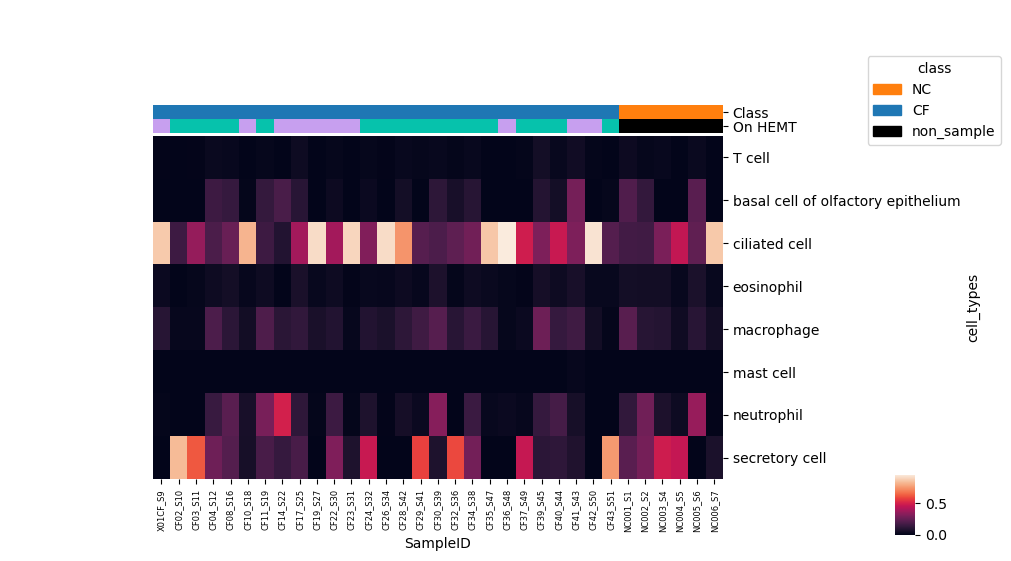

In [35]:
ax = sns.clustermap(
    proportions_bulk, 
    col_cluster=False, 
    row_cluster=False, 
    col_colors=color_df,
    xticklabels=sample_order_bulk,
    figsize=(10, 6),
    cbar_pos=(0.9, 0.1, 0.02, 0.1),
)

ax.ax_heatmap.tick_params(axis="x", rotation=90, labelsize=6)

ax.ax_col_colors.legend(
    [mpl.patches.Patch(color=x) for x in genotype_to_color.values()],
    ["NC", "CF", "non_sample"],
    bbox_to_anchor=(1.5, 3),
    frameon=True,
    title="class"
)

plt.show()

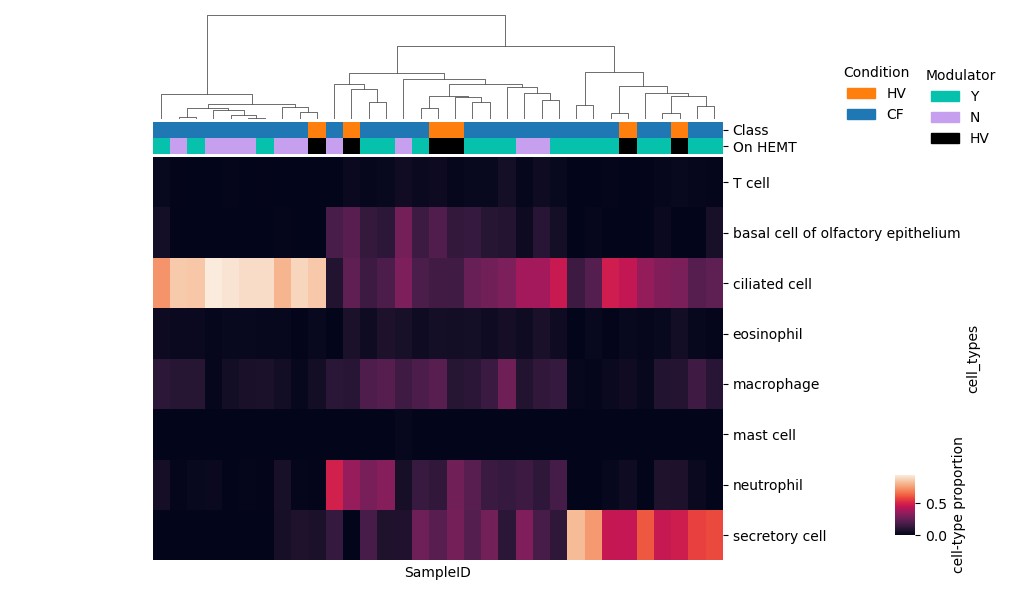

In [37]:
ax = sns.clustermap(
    proportions_bulk, 
    col_cluster=True, 
    row_cluster=False, 
    col_colors=color_df,
    #xticklabels=sample_order_bulk,
    xticklabels=False,
    figsize=(10, 6),
    cbar_pos=(0.9, 0.1, 0.02, 0.1),
    cbar_kws={'label': 'cell-type proportion'}
)

ax.ax_heatmap.tick_params(axis="x", rotation=90, labelsize=6)

ax.ax_col_dendrogram.legend(
    [mpl.patches.Patch(color=x) for x in genotype_to_color.values()],
    ["HV", "CF"],
    bbox_to_anchor=(1.35, 0.6),
    frameon=False,
    title="Condition"
)

ax.ax_col_colors.legend(
    [mpl.patches.Patch(color=x) for x in HEMT_to_color.values()],
    ['Y', 'N', 'HV'],
    bbox_to_anchor= (1.5, 3),
    frameon=False,
    title="Modulator"
)

plt.savefig('/home/trc891/projects/cyb/2022-CFnose/data/10paper_figures/fig1/fig1c.png')
plt.show()

In [38]:
proportions_bulk.T.describe()

cell_types,T cell,basal cell of olfactory epithelium,ciliated cell,eosinophil,macrophage,mast cell,neutrophil,secretory cell
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,0.013571,0.062733,0.452297,0.030157,0.099640,0.000510,0.103636,0.237454
std,0.013097,0.078147,0.294910,0.019577,0.065563,0.002702,0.123489,0.239376
min,0.000000,0.000000,0.088124,0.000000,0.009070,0.000000,0.000000,0.000000
25%,0.001276,0.000000,0.212930,0.016865,0.045556,0.000000,0.007665,0.058670
50%,0.012497,0.029364,0.307728,0.025673,0.096703,0.000000,0.058841,0.179969
75%,0.020674,0.111390,0.810263,0.044430,0.136315,0.000000,0.145637,0.453877
max,0.049052,0.282357,0.944192,0.070850,0.263365,0.015537,0.492518,0.826138


## Deconvolve Sala Samples

In [39]:
gene2symbol = tx2gene[['GENEID', 'GENENAME']].drop_duplicates(subset='GENEID').set_index('GENEID').to_dict()['GENENAME']
gene2symbol

{'ENSG00000142611': 'PRDM16',
 'ENSG00000284616': 'ENSG00000284616',
 'ENSG00000157911': 'PEX10',
 'ENSG00000260972': 'ENSG00000260972',
 'ENSG00000224340': 'RPL21P21',
 'ENSG00000229280': 'EEF1DP6',
 'ENSG00000142655': 'PEX14',
 'ENSG00000232596': 'LINC01646',
 'ENSG00000231510': 'LINC02782',
 'ENSG00000149527': 'PLCH2',
 'ENSG00000171621': 'SPSB1',
 'ENSG00000272235': 'ENSG00000272235',
 'ENSG00000284694': 'ENSG00000284694',
 'ENSG00000224387': 'ENSG00000224387',
 'ENSG00000142583': 'SLC2A5',
 'ENSG00000284674': 'LINC02781',
 'ENSG00000224338': 'MTCYBP45',
 'ENSG00000287727': 'ENSG00000287727',
 'ENSG00000173614': 'NMNAT1',
 'ENSG00000215720': 'MFFP1',
 'ENSG00000241326': 'ENSG00000241326',
 'ENSG00000233623': 'PGAM1P11',
 'ENSG00000204624': 'DISP3',
 'ENSG00000142606': 'MMEL1',
 'ENSG00000225931': 'ENSG00000225931',
 'ENSG00000171729': 'TMEM51',
 'ENSG00000229393': 'ENSG00000229393',
 'ENSG00000287586': 'ENSG00000287586',
 'ENSG00000227169': 'ENSG00000227169',
 'ENSG00000283356': 'E

In [40]:
SERIAL_DIR = '../../data/12sala_serial'
serial_fname = f'{SERIAL_DIR}/htseq.all.counts.txt'

serial_ds = pd.read_csv(serial_fname, sep='\t', index_col=0)
serial_ds.drop(['Chr', 'Start', 'End', 'Length', 'Strand'], axis=1, inplace=True)

In [41]:
def replace_if_present(x, d=gene2symbol):
    try:
        return d[x]
    except:
        return x
    
serial_ds = serial_ds.set_index(serial_ds.index.map(replace_if_present))

In [42]:
serial_bulk_ds = sc.AnnData(serial_ds.T)
serial_bulk_ds

/home/trc891/.conda/envs/cfn_final/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 48 × 60279

In [43]:
serial_bulk_ds.var_names_make_unique()
serial_bulk_ds = removeReplicas(serial_bulk_ds) # this takes a while...

/home/trc891/.conda/envs/cfn_final/lib/python3.10/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(


View of AnnData object with n_obs × n_vars = 48 × 60271


In [44]:
serial_bulk_proc = serial_bulk_ds.copy()
sc.pp.normalize_per_cell(serial_bulk_proc, counts_per_cell_after=1e4, copy=False)

In [45]:
absent_serial_bulk = shared_hv[~np.isin(shared_hv, serial_bulk_proc.var_names)]
print(absent_serial_bulk)
print(len(absent_serial_bulk))

['ADORA3' 'CCDC39' 'MIR133A1' 'MIR142' 'MIR1539' 'MIR223' 'MIR24-2'
 'MIR29B1' 'MIR3150B' 'MIR3191' 'MIR378D2' 'MIR3916' 'MIR4453' 'MIR4454'
 'MIR4469' 'MIR4712' 'MIR555' 'MIR631' 'MIR941-3' 'RN7SK' 'SOD2']
21


In [46]:
absent_zeros_serial_bulk = np.zeros((serial_bulk_proc.shape[0], absent_serial_bulk.size))
new_X_serial_bulk = np.hstack([serial_bulk_proc.X, absent_zeros_serial_bulk])
new_var_serial_bulk = pd.concat([serial_bulk_proc.var, pd.DataFrame(index=absent_serial_bulk)])

serial_bulk_proc2 = sc.AnnData(new_X_serial_bulk, obs=serial_bulk_proc.obs, var=new_var_serial_bulk)
serial_bulk_hv = serial_bulk_proc2[:, shared_hv]

In [47]:
serial_bulk_hv

View of AnnData object with n_obs × n_vars = 48 × 3331
    obs: 'n_counts'

In [48]:
coef_nnls_serial_bulk = ag.deconvolve(serial_bulk_hv.X, model='nnls') #model='nusvr'
coef_nnls_serial_bulk.shape

(48, 8)

In [49]:
proportions_nnls_serial_bulk = pd.DataFrame(data=coef_nnls_serial_bulk.T, index=centroids_sc_pareto.columns, columns=serial_bulk_hv.obs_names)
proportions_nnls_norm_serial_bulk = normalize_proportions(proportions_nnls_serial_bulk.T, copy=True).T

proportions_nnls_norm_serial_bulk = proportions_nnls_norm_serial_bulk.set_index(proportions_nnls_norm_serial_bulk.index)
proportions_nnls_norm_serial_bulk = proportions_nnls_norm_serial_bulk.astype(float)

proportions_serial_bulk = proportions_nnls_norm_serial_bulk.copy()#loc[:,real_prop.index]

In [50]:
proportions_serial_bulk

,CFNE2_CF10_CF003.1,CFNE2_CF11_CF003.2,CFNE2_CF12_CF004.1,CFNE2_CF13_CF005.1,CFNE2_CF14_CF006.1,CFNE2_CF15_CF006.2,CFNE2_CF16_CF006.3,CFNE2_CF17_CF007.1,CFNE2_CF18_CF007.2,CFNE2_CF19_CF007.3,...,CFNE2_N2_N002,CFNE2_N3_N003,CFNE2_N4_N004,CFNE2_N5_N005,CFNE2_N6_N006,CFNE2_N7_N007,CFNE2_N8_N008,CFNE2_N9_N009,uhrna1,uhrna2
cell_types,,,,,,,,,,,,,,,,,,,,,
T cell,0.013084,0.000000,0.036599,0.000000,0.007544,0.004411,0.000000,0.000000,0.000000,0.014487,...,0.008777,0.000000,0.002946,0.0,0.000000,0.004160,0.000000,0.000000,0.166344,0.183743
basal cell of olfactory epithelium,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016742,0.000000,0.088196,0.051351,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.088841,0.092589
ciliated cell,0.733945,0.171970,0.488319,0.011469,0.000000,0.054749,0.013383,0.354818,0.024979,0.052159,...,0.234200,0.364252,0.276759,0.0,0.025439,0.546051,0.956266,0.156725,0.275727,0.231829
eosinophil,0.000000,0.000000,0.000000,0.000000,0.000000,0.044741,0.016567,0.000000,0.000000,0.024152,...,0.000000,0.005721,0.011849,0.0,0.000000,0.066952,0.002034,0.003656,0.229995,0.257540
macrophage,0.142959,0.005440,0.326708,0.015790,0.080758,0.127992,0.069833,0.000000,0.119549,0.238740,...,0.174855,0.013607,0.070231,0.0,0.003030,0.075610,0.021150,0.048209,0.213284,0.216581
mast cell,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000010,0.000428
neutrophil,0.000000,0.000000,0.011272,0.402099,0.000000,0.372988,0.849817,0.000000,0.537500,0.370286,...,0.000000,0.005501,0.000115,0.0,0.017088,0.307226,0.010366,0.006310,0.025798,0.017290
secretory cell,0.110012,0.822591,0.137102,0.570643,0.911698,0.395119,0.033659,0.645182,0.229776,0.248826,...,0.582168,0.610920,0.638100,1.0,0.954443,0.000000,0.010185,0.785100,0.000000,0.000000


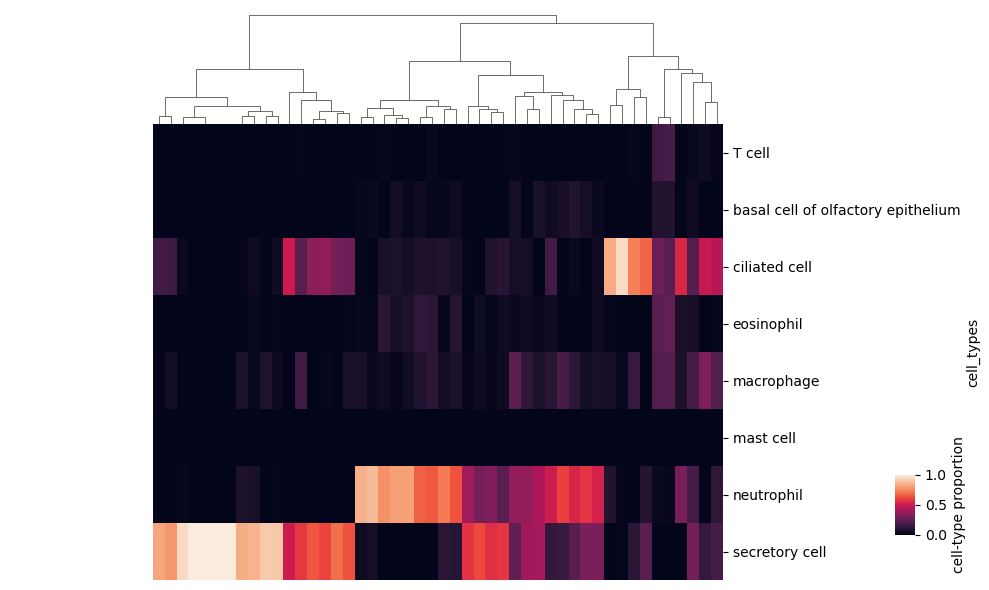

In [51]:
ax = sns.clustermap(
    proportions_serial_bulk, 
    col_cluster=True, 
    row_cluster=False, 
    #col_colors=color_df,
    #xticklabels=sample_order_bulk,
    xticklabels=False,
    figsize=(10, 6),
    cbar_pos=(0.9, 0.1, 0.02, 0.1),
    cbar_kws={'label': 'cell-type proportion'}
)

ax.ax_heatmap.tick_params(axis="x", rotation=90, labelsize=6)

#ax.ax_col_dendrogram.legend(
#    [mpl.patches.Patch(color=x) for x in genotype_to_color.values()],
#    ["HV", "CF"],
#    bbox_to_anchor=(1.35, 0.6),
#    frameon=False,
#    title="Condition"
#)

#ax.ax_col_colors.legend(
#    [mpl.patches.Patch(color=x) for x in hemt_to_color.values()],
#    ['Y', 'N', 'HV'],
#    bbox_to_anchor= (1.5, 3),
#    frameon=False,
#    title="HEMT"
#)

#plt.savefig('/home/trc891/projects/cyb/2022-CFnose/data/10paper_figures/fig1/fig3c.png')
plt.show()

In [52]:
sel_samples = ['CFNE2_CF4_10A.2', 'CFNE2_CF5_10A.3',
               'CFNE2_CF1_1A.2', 'CFNE2_CF2_1A.3',
               'CFNE2_CF8_CF002.1', 'CFNE2_CF9_CF002.2',
               'CFNE2_CF10_CF003.1', 'CFNE2_CF11_CF003.2',
               'CFNE2_CF14_CF006.1', 'CFNE2_CF15_CF006.2',
               'CFNE2_CF17_CF007.1', 'CFNE2_CF18_CF007.2',
               'CFNE2_CF27_CF012.1', 'CFNE2_CF28_CF012.2',
              ]

proportions_serial_bulk_sel = proportions_serial_bulk.loc[:, sel_samples]
proportions_serial_bulk_sel

,CFNE2_CF4_10A.2,CFNE2_CF5_10A.3,CFNE2_CF1_1A.2,CFNE2_CF2_1A.3,CFNE2_CF8_CF002.1,CFNE2_CF9_CF002.2,CFNE2_CF10_CF003.1,CFNE2_CF11_CF003.2,CFNE2_CF14_CF006.1,CFNE2_CF15_CF006.2,CFNE2_CF17_CF007.1,CFNE2_CF18_CF007.2,CFNE2_CF27_CF012.1,CFNE2_CF28_CF012.2
cell_types,,,,,,,,,,,,,,
T cell,0.003928,0.000000,0.000000,0.000000,0.010387,0.000000,0.013084,0.000000,0.007544,0.004411,0.000000,0.000000,0.003175,0.0
basal cell of olfactory epithelium,0.032358,0.000000,0.057083,0.040846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.088196,0.047237,0.0
ciliated cell,0.060105,0.674269,0.000000,0.171579,0.451505,0.835715,0.733945,0.171970,0.000000,0.054749,0.354818,0.024979,0.072119,0.0
eosinophil,0.094086,0.001684,0.000000,0.045874,0.011885,0.010394,0.000000,0.000000,0.000000,0.044741,0.000000,0.000000,0.059509,0.0
macrophage,0.067715,0.000000,0.049954,0.102319,0.213667,0.061674,0.142959,0.005440,0.080758,0.127992,0.000000,0.119549,0.012199,0.0
mast cell,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
neutrophil,0.640292,0.094797,0.577631,0.505327,0.126279,0.092218,0.000000,0.000000,0.000000,0.372988,0.000000,0.537500,0.805762,0.0
secretory cell,0.101516,0.229250,0.315332,0.134053,0.186277,0.000000,0.110012,0.822591,0.911698,0.395119,0.645182,0.229776,0.000000,1.0


In [53]:
serial_samples_demo = pd.DataFrame({'subj': [x.split('_')[2].split('.')[0] for x in sel_samples],
                                    'visit': [x.split('_')[2].split('.')[1] for x in sel_samples]
                                   },
                                   index=sel_samples
                                  )

serial_samples_demo.loc['CFNE2_CF1_1A.2', 'visit'] = '1'
serial_samples_demo.loc['CFNE2_CF4_10A.2', 'visit'] = '1'
serial_samples_demo.loc['CFNE2_CF2_1A.3', 'visit'] = '2'
serial_samples_demo.loc['CFNE2_CF5_10A.3', 'visit'] = '2'

serial_samples_demo

,subj,visit
CFNE2_CF4_10A.2,10A,1
CFNE2_CF5_10A.3,10A,2
CFNE2_CF1_1A.2,1A,1
CFNE2_CF2_1A.3,1A,2
CFNE2_CF8_CF002.1,CF002,1
CFNE2_CF9_CF002.2,CF002,2
CFNE2_CF10_CF003.1,CF003,1
CFNE2_CF11_CF003.2,CF003,2
CFNE2_CF14_CF006.1,CF006,1
CFNE2_CF15_CF006.2,CF006,2


In [54]:
def assign_colors_to_series(s, cmap='Set2'):
    labels = s.unique()
    color_vals = sns.color_palette(cmap, n_colors=len(labels))
    color_map = dict(zip(labels, color_vals))
    return [color_map[l] for l in s]

In [55]:
serial_colors = pd.DataFrame({'subj': assign_colors_to_series(serial_samples_demo['subj'], cmap='husl'),
                              'visit': assign_colors_to_series(serial_samples_demo['visit'], cmap='Set2')
                             },
                             index=serial_samples_demo.index
                            )

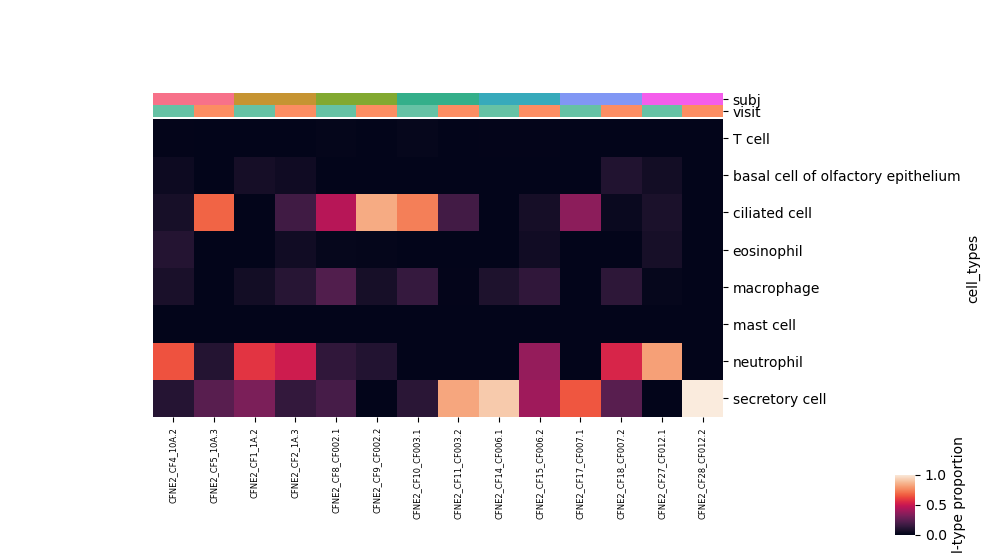

In [56]:
ax = sns.clustermap(
    proportions_serial_bulk_sel, 
    col_cluster=False, 
    row_cluster=False, 
    col_colors=serial_colors,
    xticklabels=proportions_serial_bulk_sel.columns,
    #xticklabels=False,
    figsize=(10, 6),
    cbar_pos=(0.9, 0.1, 0.02, 0.1),
    cbar_kws={'label': 'cell-type proportion'}
)

ax.ax_heatmap.tick_params(axis="x", rotation=90, labelsize=6)

#ax.ax_col_dendrogram.legend(
#    [mpl.patches.Patch(color=x) for x in genotype_to_color.values()],
#    ["HV", "CF"],
#    bbox_to_anchor=(1.35, 0.6),
#    frameon=False,
#    title="Condition"
#)

#ax.ax_col_colors.legend(
#    [mpl.patches.Patch(color=x) for x in hemt_to_color.values()],
#    ['Y', 'N', 'HV'],
#    bbox_to_anchor= (1.5, 3),
#    frameon=False,
#    title="HEMT"
#)

plt.savefig('/home/trc891/projects/cyb/2022-CFnose/data/10paper_figures/fig2/fig3c.png')
plt.show()

In [57]:
proportions_serial_bulk_sel.T.describe()

cell_types,T cell,basal cell of olfactory epithelium,ciliated cell,eosinophil,macrophage,mast cell,neutrophil,secretory cell
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.0,14.000000,14.000000
mean,0.003038,0.018980,0.257554,0.019155,0.070302,0.0,0.268057,0.362915
std,0.004401,0.029010,0.299263,0.029891,0.065413,0.0,0.291381,0.341512
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.032421,0.000000,0.007130,0.0,0.000000,0.116023
50%,0.000000,0.000000,0.121849,0.000842,0.064695,0.0,0.110538,0.229513
75%,0.004290,0.038724,0.427333,0.036527,0.115242,0.0,0.529457,0.582667
max,0.013084,0.088196,0.835715,0.094086,0.213667,0.0,0.805762,1.000000


## Sala Pre/Post Lum/Iva

In [63]:
LUMIVA_DATA_DIR = '../../data/02ireland_sala'
LUMIVA_SALMON_DIR = f'{LUMIVA_DATA_DIR}/nf_rnaseq_grch38_v113_out/star_salmon'

lumiva_nextflow_samples = pd.read_csv(f'{LUMIVA_DATA_DIR}/nf_rnaseq_samplesheet_ireland.csv')
lumiva_demo = pd.read_csv(f'{LUMIVA_DATA_DIR}/ireland_samples_20250305.csv')
tx2gene = pd.read_csv(f'{LUMIVA_SALMON_DIR}/salmon_tx2gene.tsv', sep='\t', names=["TXNAME", "GENEID", "GENENAME"])

lumiva_ct_df = pd.read_csv(f'{LUMIVA_SALMON_DIR}/salmon.merged.gene_counts.tsv', sep='\t', index_col=1)

del lumiva_ct_df['gene_id']

lumiva_demo['SampleID'] = ['X{}'.format(x) if x[0].isnumeric() else x for x in lumiva_demo['Sample']]

lumiva_bulk_ds = sc.AnnData(X=lumiva_ct_df.T, obs=lumiva_demo.set_index('SampleID'))

/home/trc891/.conda/envs/cfn_final/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [65]:
lumiva_demo

,Sample,Subj,Age,Sex,V,SampleID
0,CF_Ireland_101_V1,101.0,23.0,M,V1,CF_Ireland_101_V1
1,CF_Ireland_101_V2,101.0,23.0,M,V2,CF_Ireland_101_V2
2,CF_Ireland_102_V1,102.0,32.0,M,V1,CF_Ireland_102_V1
3,CF_Ireland_102_V2,102.0,32.0,M,V2,CF_Ireland_102_V2
4,CF_Ireland_103_V1,103.0,29.0,M,V1,CF_Ireland_103_V1
5,CF_Ireland_103_V2,103.0,29.0,M,V2,CF_Ireland_103_V2
6,CF_Ireland_104_V1,104.0,31.0,F,V1,CF_Ireland_104_V1
7,CF_Ireland_104_V2,104.0,31.0,F,V2,CF_Ireland_104_V2
8,CF_Ireland_105,105.0,NaN,NaN,NaN,CF_Ireland_105
9,CF_Ireland_106,106.0,NaN,NaN,NaN,CF_Ireland_106


In [66]:
lumiva_bulk_ds.var_names_make_unique()
lumiva_bulk_ds = removeReplicas(lumiva_bulk_ds) # this takes a while...

/home/trc891/.conda/envs/cfn_final/lib/python3.10/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(


View of AnnData object with n_obs × n_vars = 24 × 78922
    obs: 'Sample', 'Subj', 'Age', 'Sex', 'V'


In [67]:
lumiva_bulk_proc = lumiva_bulk_ds.copy()
sc.pp.normalize_per_cell(lumiva_bulk_proc, counts_per_cell_after=1e4, copy=False)

In [68]:
absent_lumiva_bulk = shared_hv[~np.isin(shared_hv, lumiva_bulk_proc.var_names)]
print(absent_lumiva_bulk)
print(len(absent_lumiva_bulk))

[]
0


In [69]:
absent_zeros_lumiva_bulk = np.zeros((lumiva_bulk_proc.shape[0], absent_lumiva_bulk.size))
new_X_lumiva_bulk = np.hstack([lumiva_bulk_proc.X, absent_zeros_lumiva_bulk])
new_var_lumiva_bulk = pd.concat([lumiva_bulk_proc.var, pd.DataFrame(index=absent_lumiva_bulk)])

lumiva_bulk_proc2 = sc.AnnData(new_X_lumiva_bulk, obs=lumiva_bulk_proc.obs, var=new_var_lumiva_bulk)
lumiva_bulk_hv = lumiva_bulk_proc2[:, shared_hv]

In [70]:
lumiva_bulk_hv

View of AnnData object with n_obs × n_vars = 24 × 3331
    obs: 'Sample', 'Subj', 'Age', 'Sex', 'V', 'n_counts'

In [71]:
coef_nnls_lumiva_bulk = ag.deconvolve(lumiva_bulk_hv.X, model='nnls') #model='nusvr'
coef_nnls_lumiva_bulk.shape

(24, 8)

In [72]:
proportions_nnls_lumiva_bulk = pd.DataFrame(data=coef_nnls_lumiva_bulk.T, index=centroids_sc_pareto.columns, columns=lumiva_bulk_hv.obs_names)
proportions_nnls_norm_lumiva_bulk = normalize_proportions(proportions_nnls_lumiva_bulk.T, copy=True).T

proportions_nnls_norm_lumiva_bulk = proportions_nnls_norm_lumiva_bulk.set_index(proportions_nnls_norm_lumiva_bulk.index)
proportions_nnls_norm_lumiva_bulk = proportions_nnls_norm_lumiva_bulk.astype(float)

proportions_lumiva_bulk = proportions_nnls_norm_lumiva_bulk.copy()#loc[:,real_prop.index]

In [73]:
proportions_lumiva_bulk

SampleID,CF_Ireland_101_V1,CF_Ireland_101_V2,CF_Ireland_102_V1,CF_Ireland_102_V2,CF_Ireland_103_V1,CF_Ireland_103_V2,CF_Ireland_104_V1,CF_Ireland_104_V2,CF_Ireland_105,CF_Ireland_106,...,CF_Ireland_109_V2,CF_Ireland_110_V1,CF_Ireland_110_V2,CF_Ireland_111_V1,CF_Ireland_111_V2,CF_Ireland_112_V1,CF_Ireland_112_V2,CF_Ireland_113,uhRNA1,uhRNA2
cell_types,,,,,,,,,,,,,,,,,,,,,
T cell,0.000000,0.021893,0.000000,0.000000,0.001353,0.007944,0.000000,0.005134,0.028236,0.000000,...,0.000000,0.000000,0.000000,0.023326,0.004411,0.000000,0.000000,0.000000,0.193256,0.195993
basal cell of olfactory epithelium,0.000000,0.058404,0.000000,0.045932,0.000000,0.019502,0.000000,0.122873,0.318858,0.011204,...,0.000000,0.133883,0.000000,0.058093,0.000000,0.000000,0.021802,0.000000,0.091731,0.087013
ciliated cell,0.874019,0.325491,0.756737,0.368089,0.051320,0.339903,0.176576,0.127355,0.185573,0.080704,...,0.565694,0.000000,0.585039,0.441959,0.913000,0.795558,0.085172,0.141523,0.242557,0.244153
eosinophil,0.000996,0.039186,0.005321,0.007104,0.005615,0.030634,0.000000,0.000000,0.066465,0.000000,...,0.000000,0.000000,0.000000,0.046878,0.027157,0.000000,0.000000,0.000000,0.239266,0.235102
macrophage,0.053010,0.197952,0.119442,0.165591,0.017582,0.103240,0.119724,0.192321,0.167323,0.085124,...,0.039810,0.045469,0.016479,0.066338,0.029330,0.013517,0.015376,0.029837,0.207417,0.212572
mast cell,0.000000,0.001031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.001713,0.000000,0.000000,0.000000,0.000000,0.004130,0.004090
neutrophil,0.071976,0.206834,0.118500,0.407792,0.000000,0.118521,0.204188,0.209980,0.158412,0.713594,...,0.394496,0.671405,0.362083,0.006958,0.011078,0.015574,0.292738,0.198030,0.021643,0.021077
secretory cell,0.000000,0.149209,0.000000,0.005492,0.924130,0.380257,0.499512,0.342337,0.075133,0.109373,...,0.000000,0.149243,0.036398,0.354735,0.015025,0.175351,0.584912,0.630610,0.000000,0.000000


In [74]:
lumiva_sel_samples = ['CF_Ireland_101_V1',
                      'CF_Ireland_101_V2',
                      'CF_Ireland_102_V1',
                      'CF_Ireland_102_V2',
                      'CF_Ireland_103_V1',
                      'CF_Ireland_103_V2',
                      'CF_Ireland_104_V1',
                      'CF_Ireland_104_V2',
                      'CF_Ireland_107_V1',
                      'CF_Ireland_107_V2',
                      'CF_Ireland_109_V1',
                      'CF_Ireland_109_V2',
                      'CF_Ireland_110_V1',
                      'CF_Ireland_110_V2',
                      'CF_Ireland_111_V1',
                      'CF_Ireland_111_V2',
                      'CF_Ireland_112_V1',
                      'CF_Ireland_112_V2']

proportions_lumiva_bulk_sel = proportions_lumiva_bulk.loc[:, lumiva_sel_samples]
proportions_lumiva_bulk_sel

SampleID,CF_Ireland_101_V1,CF_Ireland_101_V2,CF_Ireland_102_V1,CF_Ireland_102_V2,CF_Ireland_103_V1,CF_Ireland_103_V2,CF_Ireland_104_V1,CF_Ireland_104_V2,CF_Ireland_107_V1,CF_Ireland_107_V2,CF_Ireland_109_V1,CF_Ireland_109_V2,CF_Ireland_110_V1,CF_Ireland_110_V2,CF_Ireland_111_V1,CF_Ireland_111_V2,CF_Ireland_112_V1,CF_Ireland_112_V2
cell_types,,,,,,,,,,,,,,,,,,
T cell,0.000000,0.021893,0.000000,0.000000,0.001353,0.007944,0.000000,0.005134,0.016883,0.000000,0.0000,0.000000,0.000000,0.000000,0.023326,0.004411,0.000000,0.000000
basal cell of olfactory epithelium,0.000000,0.058404,0.000000,0.045932,0.000000,0.019502,0.000000,0.122873,0.000000,0.010574,0.0000,0.000000,0.133883,0.000000,0.058093,0.000000,0.000000,0.021802
ciliated cell,0.874019,0.325491,0.756737,0.368089,0.051320,0.339903,0.176576,0.127355,0.126391,0.008948,0.2456,0.565694,0.000000,0.585039,0.441959,0.913000,0.795558,0.085172
eosinophil,0.000996,0.039186,0.005321,0.007104,0.005615,0.030634,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.046878,0.027157,0.000000,0.000000
macrophage,0.053010,0.197952,0.119442,0.165591,0.017582,0.103240,0.119724,0.192321,0.198081,0.060872,0.0000,0.039810,0.045469,0.016479,0.066338,0.029330,0.013517,0.015376
mast cell,0.000000,0.001031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.001713,0.000000,0.000000,0.000000
neutrophil,0.071976,0.206834,0.118500,0.407792,0.000000,0.118521,0.204188,0.209980,0.035765,0.513571,0.7544,0.394496,0.671405,0.362083,0.006958,0.011078,0.015574,0.292738
secretory cell,0.000000,0.149209,0.000000,0.005492,0.924130,0.380257,0.499512,0.342337,0.622879,0.406035,0.0000,0.000000,0.149243,0.036398,0.354735,0.015025,0.175351,0.584912


In [75]:
lumiva_samples_demo = pd.DataFrame({'subj': [x.split('_')[2] for x in lumiva_sel_samples],
                                    'visit': [x.split('_')[3] for x in lumiva_sel_samples]
                                   },
                                   index=lumiva_sel_samples
                                  )

lumiva_samples_demo

,subj,visit
CF_Ireland_101_V1,101,V1
CF_Ireland_101_V2,101,V2
CF_Ireland_102_V1,102,V1
CF_Ireland_102_V2,102,V2
CF_Ireland_103_V1,103,V1
CF_Ireland_103_V2,103,V2
CF_Ireland_104_V1,104,V1
CF_Ireland_104_V2,104,V2
CF_Ireland_107_V1,107,V1
CF_Ireland_107_V2,107,V2


In [76]:
lumiva_colors = pd.DataFrame({'subj': assign_colors_to_series(lumiva_samples_demo['subj'], cmap='husl'),
                              'visit': assign_colors_to_series(lumiva_samples_demo['visit'], cmap='Set2')
                             },
                             index=lumiva_samples_demo.index
                            )

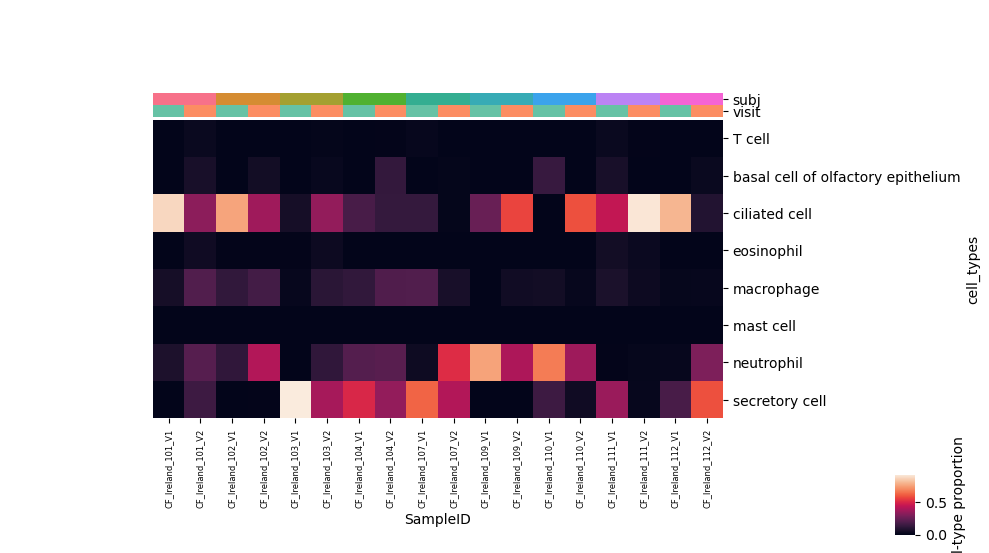

In [77]:
ax = sns.clustermap(
    proportions_lumiva_bulk_sel, 
    col_cluster=False, 
    row_cluster=False, 
    col_colors=lumiva_colors,
    xticklabels=proportions_lumiva_bulk_sel.columns,
    #xticklabels=False,
    figsize=(10, 6),
    cbar_pos=(0.9, 0.1, 0.02, 0.1),
    cbar_kws={'label': 'cell-type proportion'}
)

ax.ax_heatmap.tick_params(axis="x", rotation=90, labelsize=6)

#ax.ax_col_dendrogram.legend(
#    [mpl.patches.Patch(color=x) for x in genotype_to_color.values()],
#    ["HV", "CF"],
#    bbox_to_anchor=(1.35, 0.6),
#    frameon=False,
#    title="Condition"
#)

#ax.ax_col_colors.legend(
#    [mpl.patches.Patch(color=x) for x in hemt_to_color.values()],
#    ['Y', 'N', 'HV'],
#    bbox_to_anchor= (1.5, 3),
#    frameon=False,
#    title="HEMT"
#)

plt.savefig('/home/trc891/projects/cyb/2022-CFnose/data/10paper_figures/fig2/figS1c.png')
plt.show()